In [1]:
import time,os,json
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from train import *
from test import *
from utils.utils import *

import wandb
from tqdm import tqdm 

import torchvision
from torch.utils.data import Dataset

from einops import rearrange

import fasttext
import fasttext.util

import importlib
import main
importlib.reload(main)
from main import ConTextDataset
from main import ConTextTransformer

/anaconda/envs/xnap-project/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda
1.10.1
cuda
1.10.1


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.__version__)

cuda
1.10.1


In [3]:
wandb.login()
#We save each split file to analyze them
json_file0 = './splits/split_0.json'
json_file1 = './splits/split_1.json'
json_file2 = './splits/split_2.json'

img_dir = "./data/JPEGImages/"
txt_dir = "./ocr_labels/"
no_text_dir = "./no_text_images"

input_size = 256
data_transforms_train = torchvision.transforms.Compose([
            torchvision.transforms.RandomResizedCrop(input_size),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomRotation(15),
            torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            torchvision.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
data_transforms_test = torchvision.transforms.Compose([
        torchvision.transforms.Resize(input_size),
        torchvision.transforms.CenterCrop(input_size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: 1633623 (uabmatcad). Use `wandb login --relogin` to force relogin


In [4]:
model0 = ConTextTransformer(image_size=input_size, num_classes=28, channels=3, dim=256, depth=2, heads=4, mlp_dim=512)
model1 = ConTextTransformer(image_size=input_size, num_classes=28, channels=3, dim=256, depth=2, heads=4, mlp_dim=512)
model2 = ConTextTransformer(image_size=input_size, num_classes=28, channels=3, dim=256, depth=2, heads=4, mlp_dim=512)

# Load the state dictionary with the same model
model0.load_state_dict(torch.load('all_best_split0_resnet152.pth'))
model1.load_state_dict(torch.load('all_best_split1_resnet152.pth'))
model2.load_state_dict(torch.load('all_best_split2_resnet152.pth'))


<All keys matched successfully>

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model0.to(device)
model1.to(device)
model2.to(device)

# Set the model to evaluation mode
model0.eval()
model1.eval()
model2.eval()

ConTextTransformer(
  (resnet152): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [6]:
#split0
train_set0 = ConTextDataset(json_file0, img_dir, txt_dir,no_text_dir,True, data_transforms_train)
train_loader0 = torch.utils.data.DataLoader(train_set0, batch_size=64, shuffle=True, num_workers=8)
test_set0  = ConTextDataset(json_file0, img_dir, txt_dir,no_text_dir,False, data_transforms_test)
test_loader0 = torch.utils.data.DataLoader(test_set0, batch_size=64, shuffle=False, num_workers=8)
test_loss_history0 = []
#split1
train_set1 = ConTextDataset(json_file1, img_dir, txt_dir,no_text_dir, True, data_transforms_train)
train_loader1 = torch.utils.data.DataLoader(train_set1, batch_size=64, shuffle=True, num_workers=8)
test_set1  = ConTextDataset(json_file1, img_dir, txt_dir,no_text_dir,False, data_transforms_test)
test_loader1 = torch.utils.data.DataLoader(test_set1, batch_size=64, shuffle=False, num_workers=8)
test_loss_history1 = []
#split2
train_set2 = ConTextDataset(json_file2, img_dir, txt_dir,no_text_dir, True, data_transforms_train)
train_loader2 = torch.utils.data.DataLoader(train_set2, batch_size=64, shuffle=True, num_workers=8)
test_set2  = ConTextDataset(json_file2, img_dir, txt_dir,no_text_dir,False, data_transforms_test)
test_loader2 = torch.utils.data.DataLoader(test_set2, batch_size=64, shuffle=False, num_workers=8)
test_loss_history2 = []

/anaconda/envs/xnap-project/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F
#We modify the evaluate function so it returns bad predicted images and its predicted class
def evaluate(model, data_loader, loss_history, device="cuda"):
    model.eval()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    # Initialize array to store bad-predicted images
    bad_predicted_images = [[] for _ in range(28)] #Total number of classes
    bad_predicted_pred_images = [[] for _ in range(28)]


    with torch.no_grad():
        for data_img, data_txt, txt_mask, target in data_loader:
            data_img = data_img.to(device)
            data_txt = data_txt.to(device)
            txt_mask = txt_mask.to(device)
            target = target.to(device)
            output = F.log_softmax(model(data_img, data_txt, txt_mask), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

            # Check if prediction is incorrect
            incorrect_mask = pred.ne(target)
            incorrect_indices = incorrect_mask.nonzero(as_tuple=False).squeeze()

            # Save bad-predicted images
            for idx in incorrect_indices.flatten():
                true_class_idx = target[idx].item()
                predicted_class_idx = pred[idx].item()
                bad_predicted_images[target[idx].item()].append(data_img[idx].cpu().numpy())
                bad_predicted_pred_images[true_class_idx].append(predicted_class_idx)

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
        '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
        '{:5}'.format(total_samples) + ' (' +
        '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')


    return correct_samples / total_samples, bad_predicted_images, bad_predicted_pred_images


Let's compare the multimodal model's accuracies between each other

In [8]:
acc0, bad_predicted_images0, bad_predicted_pred_images0 = evaluate(model0, test_loader0, test_loss_history0)

/anaconda/envs/xnap-project/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Average test loss: 0.7159  Accuracy: 6499/ 8076 (80.47%)



In [9]:
acc1, bad_predicted_images1, bad_predicted_pred_images1 = evaluate(model1, test_loader1, test_loss_history1)


Average test loss: 0.6762  Accuracy: 6549/ 8076 (81.09%)



In [10]:
acc2, bad_predicted_images2, bad_predicted_pred_images2 = evaluate(model2, test_loader2, test_loss_history2)


Average test loss: 0.6980  Accuracy: 6564/ 8103 (81.01%)



Let's now visualize the distribution of each class of each 3 splits in a plot bar.

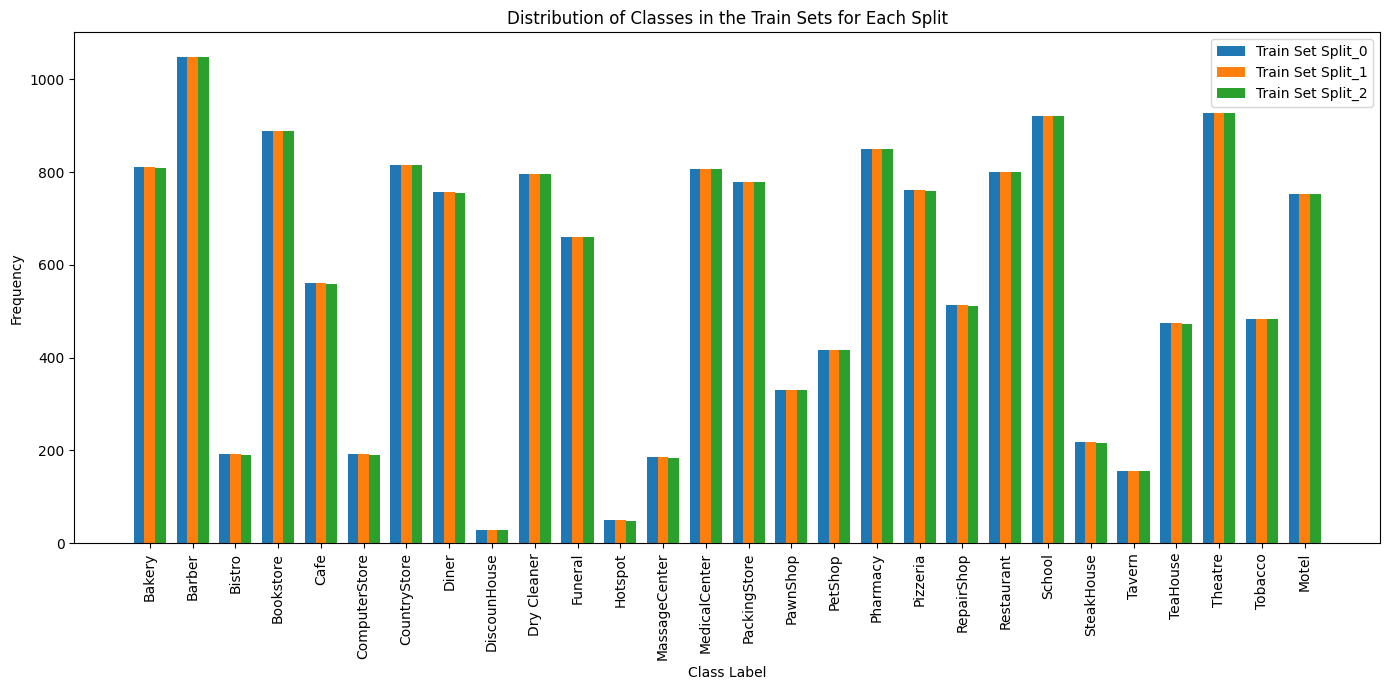

In [13]:
class_labels = {1: "Bakery", 2: "Barber", 3: "Bistro", 4: "Bookstore", 5: "Cafe", 6: "ComputerStore", 7: "CountryStore", 8: "Diner", 9: "DiscounHouse", 10: "Dry Cleaner", 11: "Funeral", 12: "Hotspot", 13: "MassageCenter", 14: "MedicalCenter", 15: "PackingStore", 16: "PawnShop", 17: "PetShop", 18: "Pharmacy", 19: "Pizzeria", 20: "RepairShop", 21: "Restaurant", 22: "School", 23: "SteakHouse", 24: "Tavern", 25: "TeaHouse", 26: "Theatre", 27: "Tobacco", 28: "Motel"}

# Initialize arrays to store the counts for each class for each split
num_classes = 28
class_counts_train = np.zeros((3, num_classes), dtype=int)

# Collect class labels and count occurrences in the train set for each split
for idx, train_set in enumerate([train_set0, train_set1, train_set2]):
    for _, _, _, target in train_set:
        class_counts_train[idx][target] += 1

# Plot the distribution
plt.figure(figsize=(14, 7))
bar_width = 0.25
indices = np.arange(1, num_classes + 1)

# Plot train set distribution for each split
for i in range(3):
    plt.bar(indices + (i - 1) * bar_width, class_counts_train[i], bar_width, label=f'Train Set Split_{i}')

plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Distribution of Classes in the Train Sets for Each Split')
plt.xticks(indices, [class_labels[i] for i in range(1, num_classes + 1)], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

We can see that each split has the same number of images per class, so as we have seen before, the accuracy does not significantly change 